In [69]:
#Libraries to import.
%matplotlib inline
import pylab as plt
from tifffile import imread
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import flood_fill
from skimage.morphology import watershed
from findmaxima2d import find_maxima, find_local_maxima #install with pip E.g.: python3 -m pip install findmaxima2d
import os

# Reading the folders : #

In [77]:
from os import listdir
from os.path import isfile, join
pathX = './DAPI-test'
pathY = './FITC-test'
pathZ = './TRITC-test'
pathA = './CY-test'

X_files = [pathX+'/'+f for f in listdir(pathX) if isfile(join(pathX, f))]
Y_files = [pathY+'/'+f for f in listdir(pathY) if isfile(join(pathY, f))]
Z_files = [pathZ+'/'+f for f in listdir(pathZ) if isfile(join(pathZ, f))]
A_files = [pathA+'/'+f for f in listdir(pathA) if isfile(join(pathA, f))]

#print(X_files)

#create tuple for four images
#to read images with there id value

tupleXYZA = []

for d,f,t,c in zip(X_files, Y_files, Z_files, A_files):
    tupleXYZA.append((d,f,t,c))
print('Tuple list=', tupleXYZA)
len(tupleXYZA)

Tuple list= [('./DAPI-test/DAPI0617.tif', './FITC-test/FITC0617.tif', './TRITC-test/TRITC0617.tif', './CY-test/Cy0617.tif')]


1

# Reading the images : #

In [78]:
def read_img(X,Y,Z,A):
    ch0 = imread(X).astype(np.float64) #Dapi channel
    ch1 = imread(Y).astype(np.float64) #FITC channel
    ch2 = imread(Z).astype(np.float64) #TRITC channel
    ch3 = imread(A).astype(np.float64) #Cy5 channel
    plt.figure(figsize=(32,32))
    plt.subplot(1,4,1)
    plt.imshow(ch0) # show image from Dapi Channel
    plt.subplot(1,4,2)
    plt.imshow(ch1) # show image from FITC Channel
    plt.subplot(1,4,3)
    plt.imshow(ch2) # show image from TRITC Channel
    plt.subplot(1,4,4)
    plt.imshow(ch3) # # show image from Cy5 Channel
    return(ch0,ch1,ch2,ch3)


# Main function : #

In [79]:
#The first stage in the maxima finding algorithm is to find the local maxima, this can be achieved in different ways 
#but usually represents the identification of the maximum pixel in each 3x3 neighbourhood (in the default case). 
#Once the local maxima have been identified it is then possible to find the maxima across an image.
#install with pip E.g.: python3 -m pip install findmaxima2d

def colocalization(ch0,ch1,ch2,ch3,ind):
    
    thresh = threshold_otsu(ch0)
    binary = ch0 > thresh
    dist = ndimage.distance_transform_edt(binary)
    ntol = 100 #noise tolerence in pixels to check/scan neighboring maxima  
    img_data = np.array(dist).astype(np.float64)
    img_data = (img_data/np.max(img_data))*255
    local_max = find_local_maxima(img_data)
    y,x,out, = find_maxima(img_data, local_max.astype(np.uint8),ntol)
    local_maxi = np.zeros(ch0.shape)
    local_maxi[y,x] = 1
    markers, num = ndimage.label(local_maxi)
    labels = watershed(-dist, markers, mask=binary)
    
    data = {'cell_num':np.arange(1,num+1),'pts_ch0':None,'pts_ch1':None,'pts_ch2':None}
    pd.set_option('display.max_rows', None)
    df = pd.DataFrame(data)
    
    #finding maxima or peak(object) on Dapi channel 
    ntol1 = 100 
    img_data = np.array(ch0)
    img_data = (img_data/np.max(img_data))*255
    local_max = find_local_maxima(img_data)
    ych0,xch0, out = find_maxima(img_data, local_max.astype(np.uint8),ntol1)
    
    #finding maxima or peak(object) on FITC channel
    ntol1 = 100 
    img_data = np.array(ch1)
    img_data = (img_data/np.max(img_data))*255
    local_max = find_local_maxima(img_data)
    ych1,xch1, out = find_maxima(img_data, local_max.astype(np.uint8),ntol1)
    
    #finding maxima or peak(object) on TRITC channel
    ntol1 = 100
    img_data = np.array(ch2)
    img_data = (img_data/np.max(img_data))*255
    local_max = find_local_maxima(img_data)
    ych2,xch2, out = find_maxima(img_data, local_max.astype(np.uint8),ntol1)
    
    #finding maxima or peak(object) on Cy5 channel
    ntol1 = 100
    img_data = np.array(ch3)
    img_data = (img_data/np.max(img_data))*255
    local_max = find_local_maxima(img_data)
    ych3,xch3, out = find_maxima(img_data, local_max.astype(np.uint8),ntol1)
    
    ##iteratingingly storing/appending the maxima or peak(object) value in a list   
    
    cell_ch0 = []
    cell_ch1 = []
    cell_ch2 = []
    cell_ch3 = []

    for i in range(0, num):
        cell_ch0.append([])
        cell_ch1.append([])
        cell_ch2.append([])
        cell_ch3.append([])

        bint = labels == i+1
        for yc0,xc0 in zip(ych0,xch0):
            if bint[yc0,xc0] == 1:
                cell_ch0[i].append([yc0,xc0])
        for yc1,xc1 in zip(ych1,xch1):
            if bint[yc1,xc1] == 1:
                cell_ch1[i].append([yc1,xc1])
        for yc2, xc2 in zip(ych2,xch2):
            if bint[yc2,xc2] == 1:
                cell_ch2[i].append([yc2,xc2])
        for yc3, xc3 in zip(ych3,xch3):
            if bint[yc3,xc3] == 1:
                cell_ch3[i].append([yc3,xc3])

    df['pts_ch0'] = cell_ch0 #Dapi Dataframe
    df['pts_ch1'] = cell_ch1 #FITC Dataframe
    df['pts_ch2'] = cell_ch2 #TRITC Dataframe
    df['pts_ch3'] = cell_ch3 #Cy5 Dataframe
    
    #print(df['pts_ch0'],df['pts_ch1'],df['pts_ch2'],df['pts_ch3'])

    coloc_num = []
    
   
    #add/find the colocalized points from different filters
    #in order to finding the average of 4 datapoints(from 4 filters) we need 
    #to find the distance between 6 pairs of points then take the average  
    
    for i in range(1,num+1):
        cell_ch0 = list(df[df['cell_num']==i]['pts_ch0'])[0]
        cell_ch1 = list(df[df['cell_num']==i]['pts_ch1'])[0]
        cell_ch2 = list(df[df['cell_num']==i]['pts_ch2'])[0]
        cell_ch3 = list(df[df['cell_num']==i]['pts_ch3'])[0]
        
        count =0
        global dist0
        global dist1
        global dist2
        global dist3
        global dist4
        global dist5 
       
        for pts0 in cell_ch0:
            for pts1 in cell_ch1:
                dist0 = np.sqrt((pts0[0]-pts1[0])**2 + (pts0[1]-pts1[1])**2)
        for pts0 in cell_ch0:
            for pts2 in cell_ch2:
                dist1 = np.sqrt((pts0[0]-pts2[0])**2 + (pts0[1]-pts2[1])**2)
        for pts0 in cell_ch0:
            for pts3 in cell_ch3:
                dist2 = np.sqrt((pts0[0]-pts3[0])**2 + (pts0[1]-pts3[1])**2)
        for pts1 in cell_ch1:
            for pts2 in cell_ch2: 
                dist3 = np.sqrt((pts1[0]-pts2[0])**2 + (pts1[1]-pts2[1])**2) 
        for pts1 in cell_ch1:
            for pts3 in cell_ch3:
                dist4 = np.sqrt((pts1[0]-pts3[0])**2 + (pts1[1]-pts3[1])**2)
              
        for pts2 in cell_ch2:
            for pts3 in cell_ch3:
                dist5 = np.sqrt((pts2[0]-pts3[0])**2 + (pts2[1]-pts3[1])**2)
                
        if ((dist0 + dist1 + dist2 + dist3 + dist4 + dist5)/6 < 20) :
                if (df['pts_ch0'][i-1]!=[] and len(df['pts_ch0'][i-1])!=0) and (df['pts_ch1'][i-1]!=[] and len(df['pts_ch1'][i-1])!=0) and (df['pts_ch2'][i-1]!=[] and len(df['pts_ch2'][i-1])!=0) and (df['pts_ch3'][i-1]!=[] and len(df['pts_ch3'][i-1])!=0) :
                        count +=1
        
        coloc_num.append(count)
    df['coloc_num'] = coloc_num
    plt.figure(figsize=(32,32))
    #red '+' for Dapi marker in overlay image
    plt.plot(xch0,ych0,'y+',alpha=0.5,markersize=25)
    #yellow star for FITC marker in overlay image
    plt.plot(xch1,ych1,'r*',alpha=0.5,markersize=25)
    #black diamond for TRITC marker in overlay image
    plt.plot(xch2,ych2,'kd',alpha=0.5,markersize=25)
    #white triangle for Cy5 marker in overlay image
    plt.plot(xch3,ych3,'wv',alpha=0.5,markersize=25)
    
    plt.imshow(ch0)
    #Save the pverlay image in a folder
    plt.savefig('ioutput/out'+str(ind)+'.png')
    #save the dataframe in a .csv file
    df.to_csv('iCSV/out'+str(ind)+'.csv', index=False)


('./DAPI-test/DAPI0617.tif', './FITC-test/FITC0617.tif', './TRITC-test/TRITC0617.tif', './CY-test/Cy0617.tif')


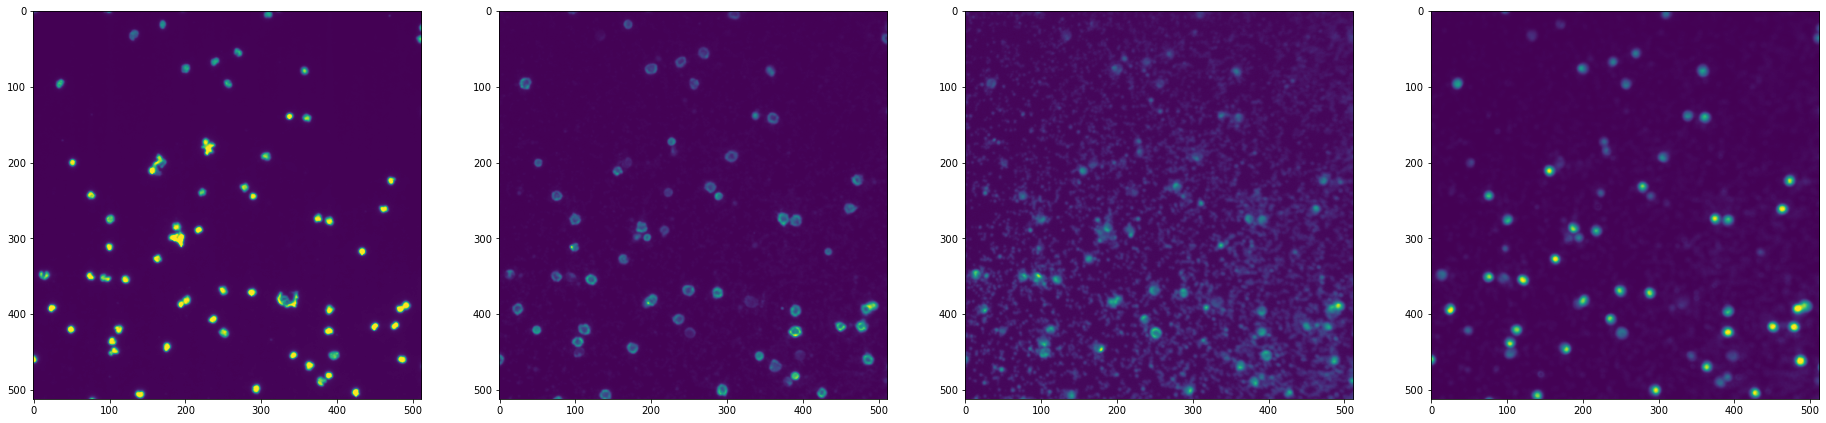

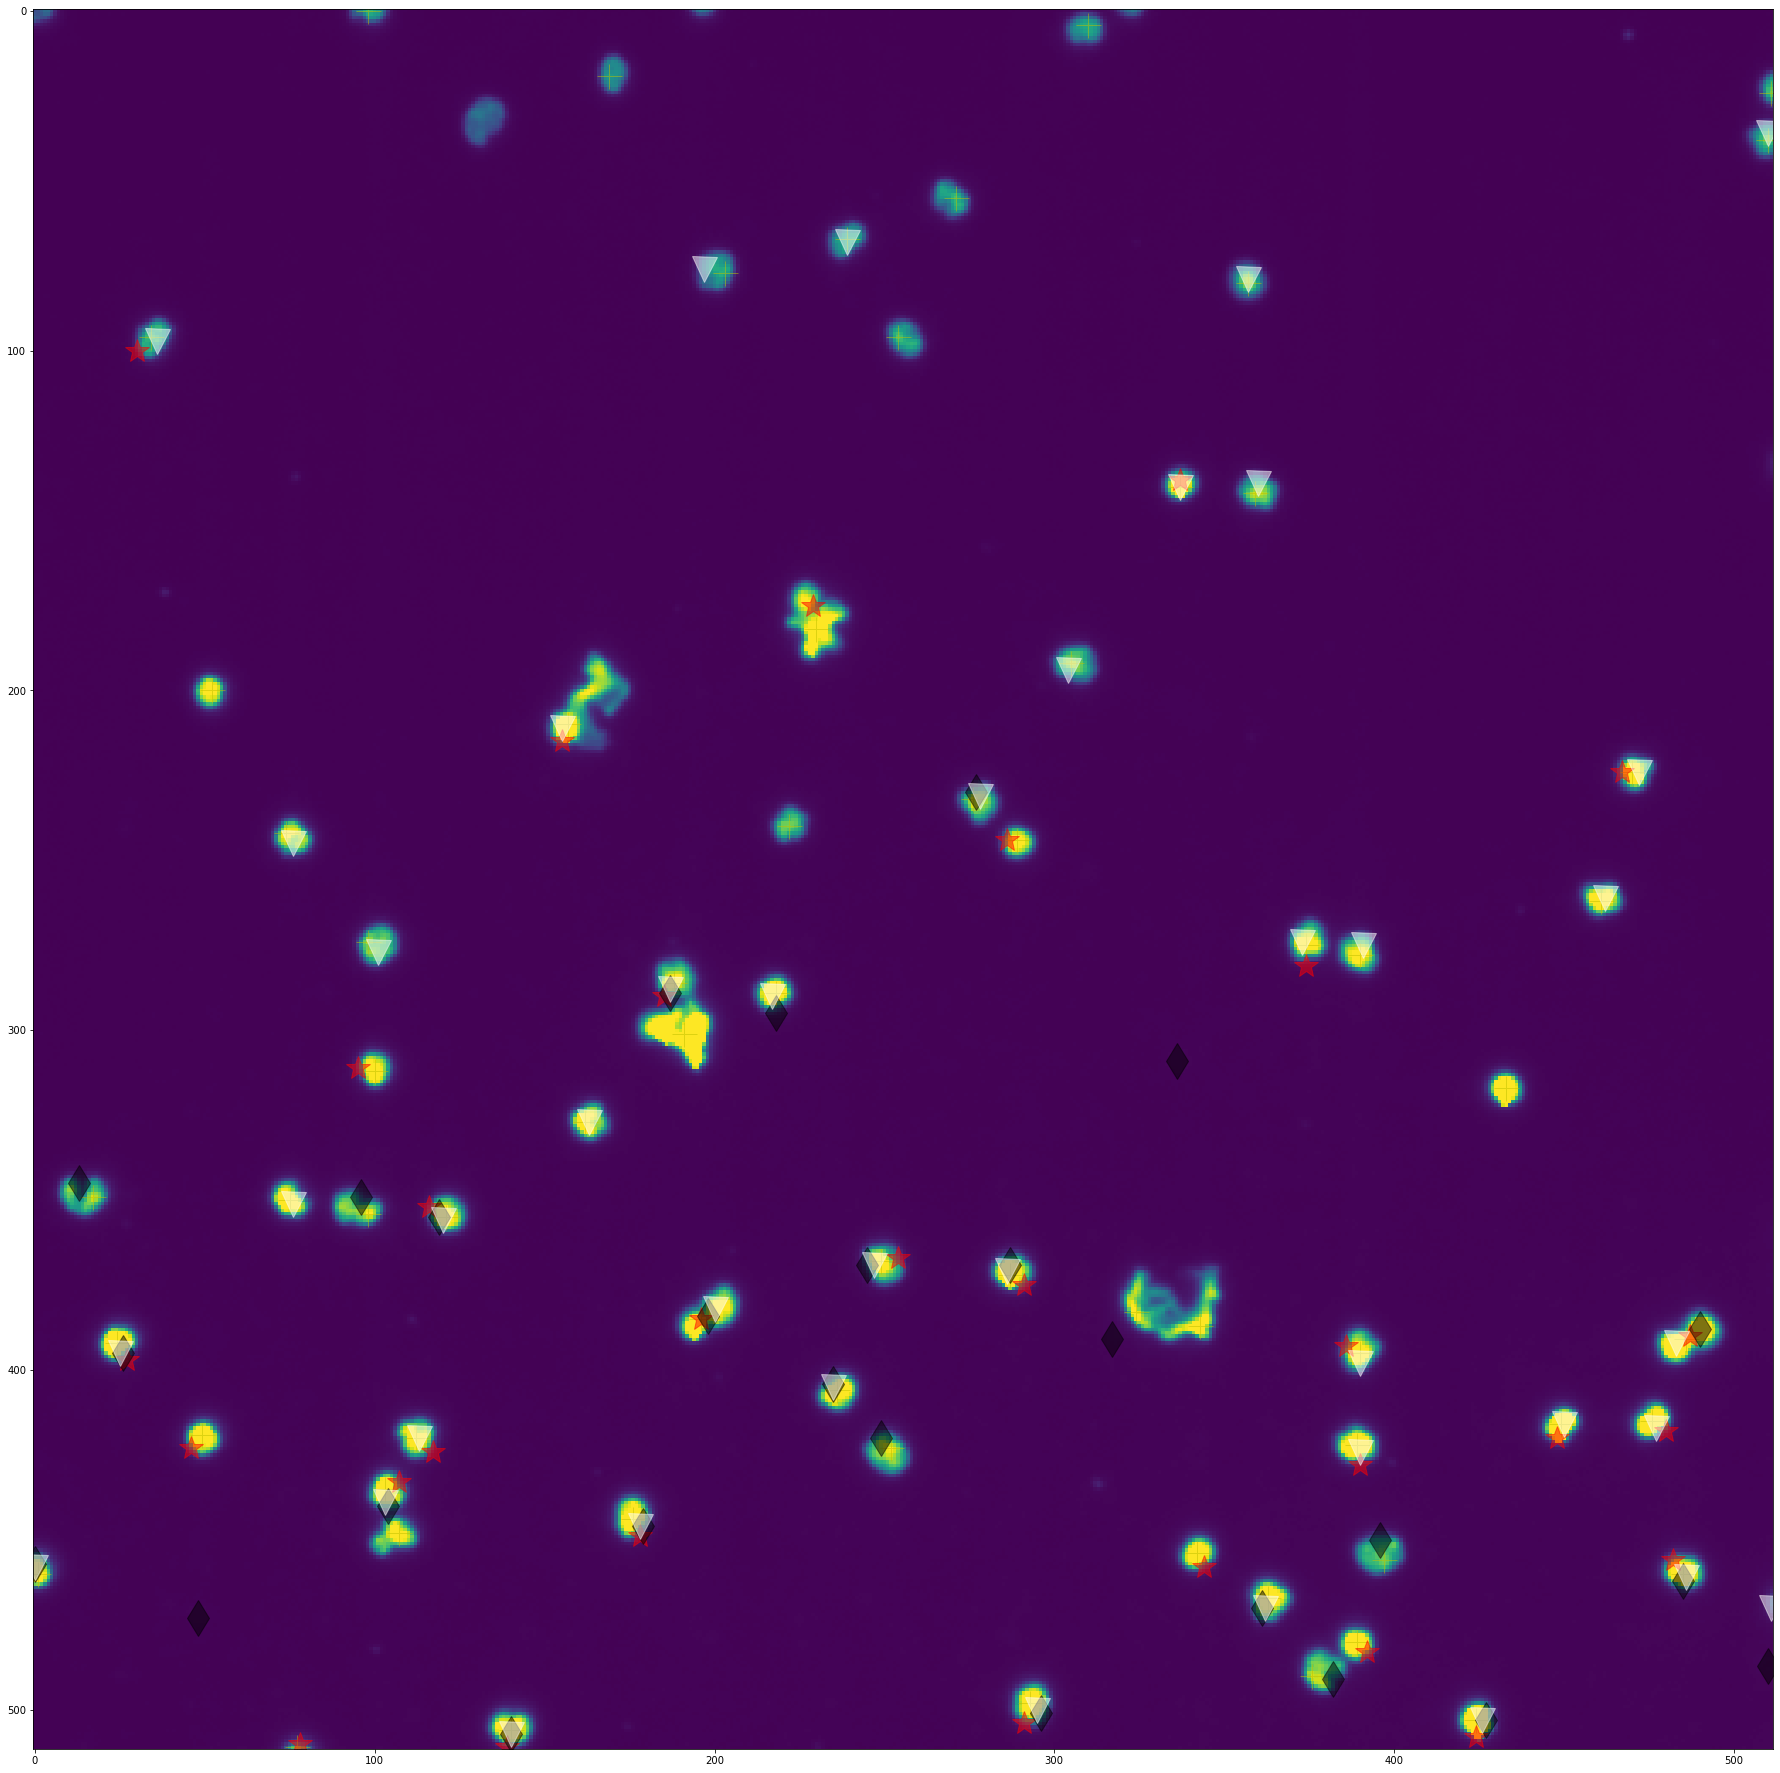

In [80]:
#call the colocalization function for batch run
ind=0
for i in tupleXYZA :
    ind+=1
    print(i) #print here to show that's work
    ch0,ch1,ch2,ch3 = read_img(i[0],i[1],i[2],i[3])
    
    colocalization(ch0,ch1,ch2,ch3,ind)
    #print(dist0,dist1,dist2,dist3,dist4,dist5)
    

In [74]:
#merge the .csv file from the folder
import os, glob
import pandas as pd

path = "./iCSV/"

all_files = glob.glob(os.path.join(path, "*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)


In [75]:
merged_df 

,cell_num,coloc_num,file,pts_ch0,pts_ch1,pts_ch2,pts_ch3
0,1,0,iCSV\out1.csv,"[[291, 298]]",[],[],[]
1,1,0,iCSV\out10.csv,"[[0, 206]]",[],[],[]
2,2,0,iCSV\out10.csv,"[[16, 89]]",[],[],[]
3,3,0,iCSV\out10.csv,"[[36, 455]]",[],[],[]
4,4,0,iCSV\out10.csv,"[[88, 325]]",[],[],[]
5,5,0,iCSV\out10.csv,"[[104, 367]]",[],[],[]
6,6,0,iCSV\out10.csv,"[[158, 175]]","[[161, 174]]",[],[]
7,7,0,iCSV\out10.csv,"[[204, 49]]","[[203, 46]]",[],"[[205, 49]]"
8,8,0,iCSV\out10.csv,"[[284, 431]]","[[284, 428]]",[],"[[284, 431]]"
9,9,0,iCSV\out10.csv,"[[307, 123]]","[[309, 121]]",[],"[[308, 123]]"


In [76]:
#find total colocalization points in one pass(patient)

Total = merged_df['coloc_num'].sum()
print(Total)

81


In [43]:
merged_df.to_csv('iCSV/patient-3-csv/Batch-900-to-1800/all.csv', index=False)